In [1]:
import sys
sys.path.append('../../astro_tools')
sys.path.append('../')
import axes_offset
import convolution

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from astropy.convolution import convolve, Box2DKernel, Tophat2DKernel, Gaussian2DKernel
# from astropy.visualization.wcsaxes import add_beam, add_scalebar


# set up the plot
import cmasher as cmr
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

import warnings
warnings.filterwarnings('ignore')

In [2]:
def line_flux(amp, sig , amp_err, sig_err):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    
    sig_Ang = (sig * 2.2) / 100
    sig_Ang_err = (sig_err * 2.2) / 100
    
    flux = amp * sig_Ang * np.sqrt(2*np.pi)
    flux_err = flux * np.sqrt((amp_err/amp)**2 + (sig_Ang_err/sig_Ang)**2)
    return flux, flux_err


def get_data(line,param,comp,err=False):
    
    """
    line must be ha, niia, niib, siia, or siib
    param must be amp, vel, or sigma
    comp must be outflow_blue, outflow_red, or disk
    
    """
    
    if err == True:
        file = '../../ngc253/muse/data/output_maps/errs/ERR_ngc253_muse_se_%s_%s_%s.fits' % (line, param, comp)
    else:
        file = '../../ngc253/muse/data/output_maps/ngc253_muse_se_%s_%s_%s.fits' % (line, param, comp)
    
    hdu = fits.open(file)
    hdu_data = hdu[0].data
    
    return(hdu_data)


def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, extent, cmap, cmap_extend,
                  alpha_outb='None', alpha_outr='None', alpha_disk='None'):
        
    cmap_alpha = cmr.get_sub_cmap('gist_gray_r', 0.0, 0.5)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outb) != str:
        print('yes')
        gray_outb = np.zeros_like(outb_dat)
        gray_outb[~np.isfinite(outb_dat)] = np.nan
        axNums[0].imshow(gray_outb, origin='lower',cmap=cmap_alpha, alpha=alpha_outb,extent=extent)
    
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_outr) != str:
        gray_outr = np.zeros_like(outr_dat)
        gray_outr[~np.isfinite(outr_dat)] = np.nan
        axNums[1].imshow(gray_outr, origin='lower',cmap=cmap_alpha, alpha=alpha_outr,extent=extent)
    
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    
    # do we want to blank out any pixels?
    if type(alpha_disk) != str:
        gray_disk = np.zeros_like(disk_dat)
        gray_disk[~np.isfinite(disk_dat)] = np.nan
        axNums[2].imshow(gray_disk, origin='lower',cmap=cmap_alpha, alpha=alpha_disk,extent=extent)
    
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax, extend=cmap_extend)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')
    
    return


In [3]:
og = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
w = wcs.WCS(hdu.header, naxis=2).celestial


ra_hms, dec_dms = axes_offset.get_offset(og_data, w)
extent = axes_offset.get_extent(dat=og_data, x_dim=2, y_dim=1, pixscale=0.2)

<SkyCoord (ICRS): (ra, dec) in deg
    (11.89324129, -25.19976396)>


### Deciding upon T = 6500 K

In [4]:
# get siib, siia amplitudes and sigmas
siib_amp_disk = get_data(line='siib', param='amp', comp='disk')
siib_amp_outb = get_data(line='siib', param='amp', comp='outflow_blue')
siib_amp_outr = get_data(line='siib', param='amp', comp='outflow_red')
siia_amp_disk = get_data(line='siia', param='amp', comp='disk')
siia_amp_outb = get_data(line='siia', param='amp', comp='outflow_blue')
siia_amp_outr = get_data(line='siia', param='amp', comp='outflow_red')

siib_sig_disk = get_data(line='siib', param='sig', comp='disk')
siib_sig_outb = get_data(line='siib', param='sig', comp='outflow_blue')
siib_sig_outr = get_data(line='siib', param='sig', comp='outflow_red')
siia_sig_disk = get_data(line='siia', param='sig', comp='disk')
siia_sig_outb = get_data(line='siia', param='sig', comp='outflow_blue')
siia_sig_outr = get_data(line='siia', param='sig', comp='outflow_red')

ERR_siib_amp_disk = get_data(line='siib', param='amp', comp='disk', err=True)
ERR_siib_amp_outb = get_data(line='siib', param='amp', comp='outflow_blue', err=True)
ERR_siib_amp_outr = get_data(line='siib', param='amp', comp='outflow_red', err=True)
ERR_siia_amp_disk = get_data(line='siia', param='amp', comp='disk', err=True)
ERR_siia_amp_outb = get_data(line='siia', param='amp', comp='outflow_blue', err=True)
ERR_siia_amp_outr = get_data(line='siia', param='amp', comp='outflow_red', err=True)

ERR_siib_sig_disk = get_data(line='siib', param='sig', comp='disk', err=True)
ERR_siib_sig_outb = get_data(line='siib', param='sig', comp='outflow_blue', err=True)
ERR_siib_sig_outr = get_data(line='siib', param='sig', comp='outflow_red', err=True)
ERR_siia_sig_disk = get_data(line='siia', param='sig', comp='disk', err=True)
ERR_siia_sig_outb = get_data(line='siia', param='sig', comp='outflow_blue', err=True)
ERR_siia_sig_outr = get_data(line='siia', param='sig', comp='outflow_red', err=True)

# convert to flux
siia_flux_disk, ERR_siia_flux_disk = line_flux(siia_amp_disk, siia_sig_disk, 
                                               ERR_siia_amp_disk, ERR_siia_sig_disk)
siia_flux_outb, ERR_siia_flux_outb = line_flux(siia_amp_outb, siia_sig_outb,
                                               ERR_siia_amp_outb, ERR_siia_sig_outb)
siia_flux_outr, ERR_siia_flux_outr = line_flux(siia_amp_outr, siia_sig_outr,
                                               ERR_siia_amp_outr, ERR_siia_sig_outr)
siib_flux_disk, ERR_siib_flux_disk = line_flux(siib_amp_disk, siib_sig_disk,
                                               ERR_siib_amp_disk, ERR_siib_sig_disk)
siib_flux_outb, ERR_siib_flux_outb = line_flux(siib_amp_outb, siib_sig_outb,
                                               ERR_siib_amp_outb, ERR_siib_sig_outb)
siib_flux_outr, ERR_siib_flux_outr = line_flux(siib_amp_outr, siib_sig_outr,
                                               ERR_siib_amp_outr, ERR_siib_sig_outr)

# take ratios
sii_disk_flux_rat = siia_flux_disk / siib_flux_disk
sii_outb_flux_rat = siia_flux_outb / siib_flux_outb
sii_outr_flux_rat = siia_flux_outr / siib_flux_outr

# create upper limit of 1.4
# sii_disk_flux_rat[sii_disk_flux_rat > 1.4] = 1.4
# sii_outb_flux_rat[sii_outb_flux_rat > 1.4] = 1.4
# sii_outr_flux_rat[sii_outr_flux_rat > 1.4] = 1.4

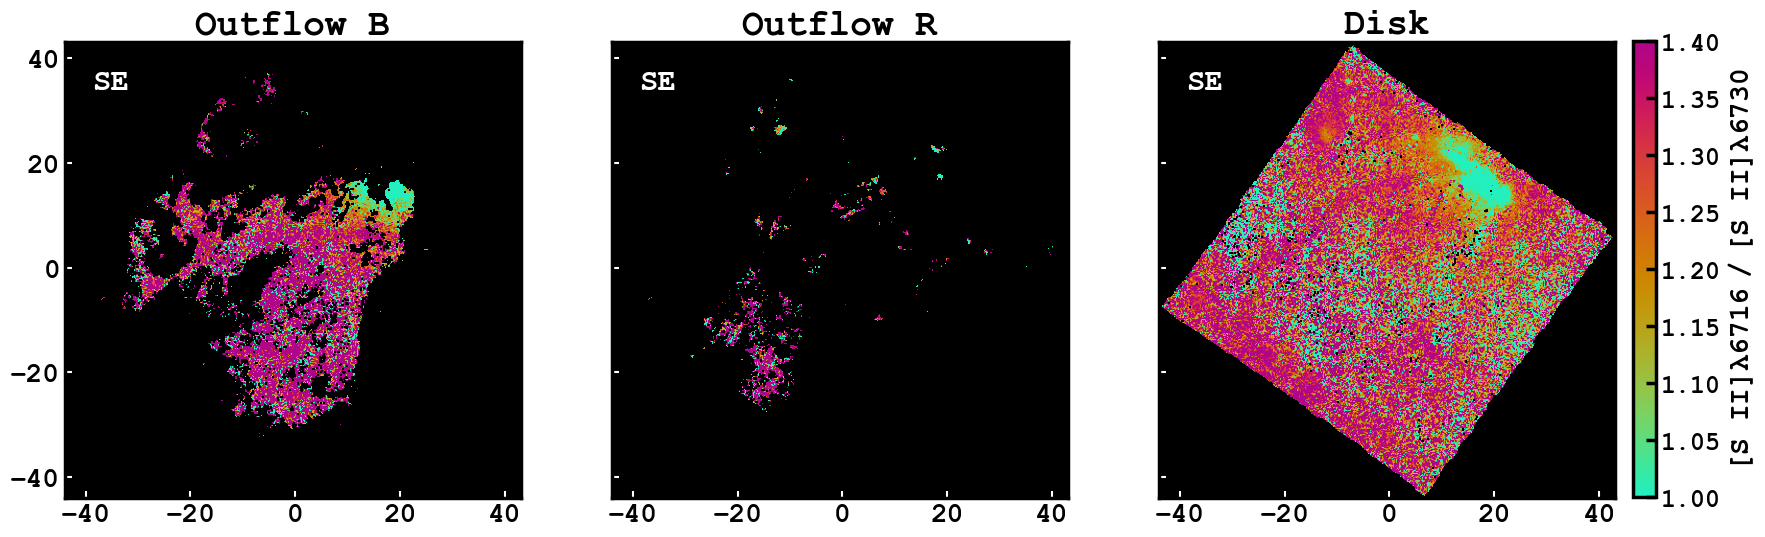

In [5]:
# first, what do the ratios look like without smoothing?
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              sii_outb_flux_rat,
              sii_outr_flux_rat,
              sii_disk_flux_rat,
              vmin = 1.0,
              vmax = 1.4,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')

In [81]:
which_smooth = 'gauss'

if which_smooth == 'gauss':
    #kern = convolution.gauss_2d_kernel(sigma=3)
    kern = Gaussian2DKernel(3)
elif which_smooth == 'box':
    kern = Box2DKernel(width=5)
elif which_smooth == 'tophat':
    kern = Tophat2DKernel(radius=3)

In [82]:
# outflow b
siia_flux_outb_smooth = convolve(siia_flux_outb, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
siib_flux_outb_smooth = convolve(siib_flux_outb, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)


# outflow r
siia_flux_outr_smooth = convolve(siia_flux_outr, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
siib_flux_outr_smooth = convolve(siib_flux_outr, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)


# disk
siia_flux_disk_smooth = convolve(siia_flux_disk, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
siib_flux_disk_smooth = convolve(siib_flux_disk, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)

np.savetxt('../../ngc253/muse/data/edens_%s/sii_outb_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_outb_smooth/siib_flux_outb_smooth)
np.savetxt('../../ngc253/muse/data/edens_%s/sii_outr_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_outr_smooth/siib_flux_outr_smooth)
np.savetxt('../../ngc253/muse/data/edens_%s/sii_disk_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_disk_smooth/siib_flux_disk_smooth)


In [84]:
# also smooth the errors

# outflow b
ERR_siia_flux_outb_smooth = convolve(ERR_siia_flux_outb, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
ERR_siib_flux_outb_smooth = convolve(ERR_siib_flux_outb, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)


# outflow r
ERR_siia_flux_outr_smooth = convolve(ERR_siia_flux_outr, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
ERR_siib_flux_outr_smooth = convolve(ERR_siib_flux_outr, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)


# disk
ERR_siia_flux_disk_smooth = convolve(ERR_siia_flux_disk, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)
ERR_siib_flux_disk_smooth = convolve(ERR_siib_flux_disk, kern, normalize_kernel=True, 
                                 fill_value=np.nan, nan_treatment='interpolate', preserve_nan=True)

np.savetxt('../../ngc253/muse/data/edens_%s/ERR_sii_outb_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_outb_smooth/siib_flux_outb_smooth)
np.savetxt('../../ngc253/muse/data/edens_%s/ERR_sii_outr_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_outr_smooth/siib_flux_outr_smooth)
np.savetxt('../../ngc253/muse/data/edens_%s/ERR_sii_disk_flux_rat_smooth.txt' % which_smooth, 
           siia_flux_disk_smooth/siib_flux_disk_smooth)

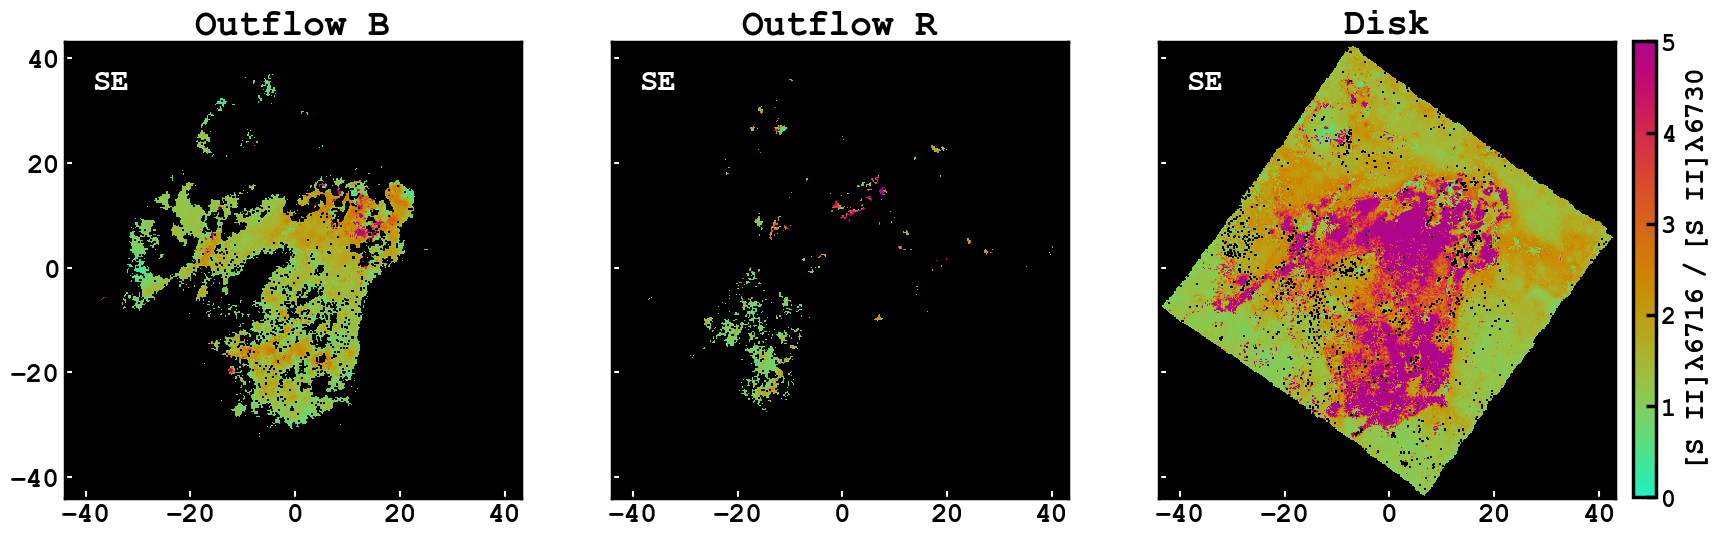

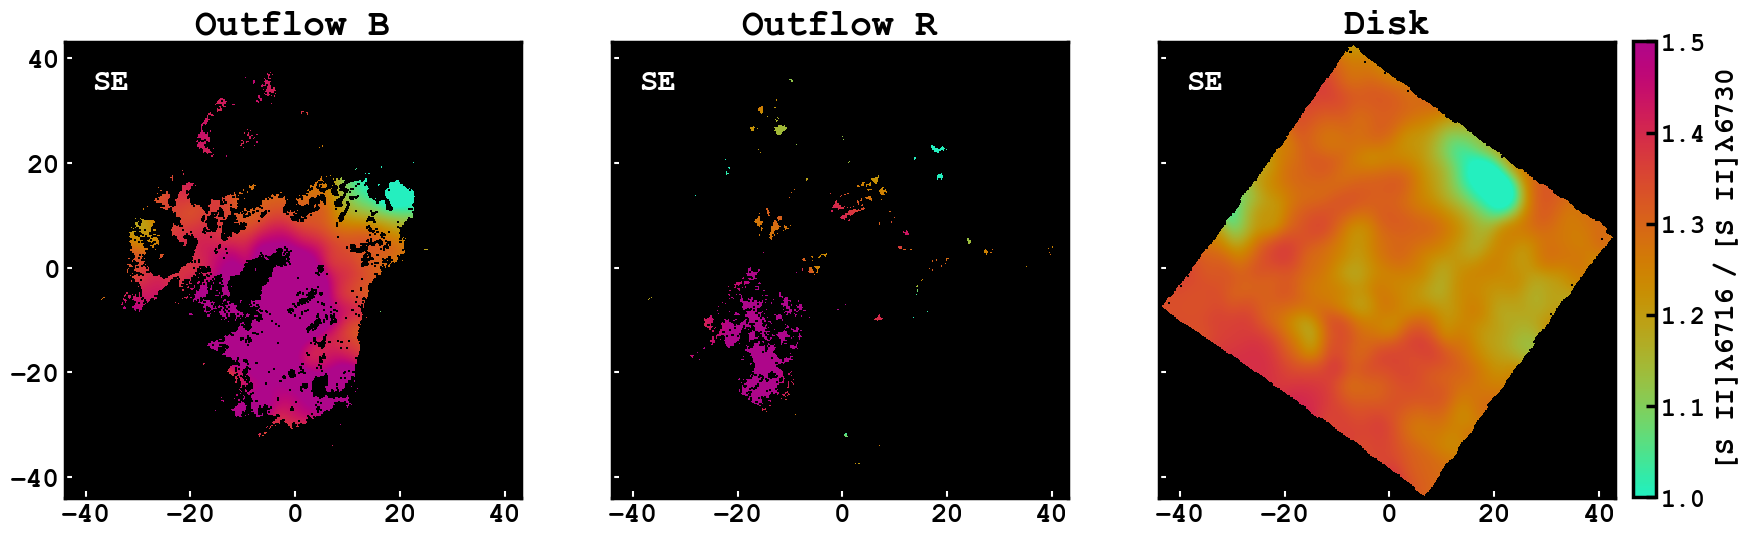

In [85]:
# unsmooth SNR
# smooth SNR
# now calculate the signal to noise
unsmooth_rats_outb = np.loadtxt('../../ngc253/muse/data/edens_old/sii_outb_flux_rat.txt')
unsmooth_rats_outr = np.loadtxt('../../ngc253/muse/data/edens_old/sii_outr_flux_rat.txt')
unsmooth_rats_disk = np.loadtxt('../../ngc253/muse/data/edens_old/sii_disk_flux_rat.txt') 

#ERR_smooth_rats_outb = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_outb_flux_rat_smooth.txt' % which_smooth)
#ERR_smooth_rats_outr = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_outr_flux_rat_smooth.txt' % which_smooth)
#ERR_smooth_rats_disk = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_disk_flux_rat_smooth.txt' % which_smooth)

unsmooth_ERR_sii_disk = unsmooth_rats_disk * np.sqrt((ERR_siia_flux_disk / siia_flux_disk)**2 + \
                       (ERR_siib_flux_disk / siib_flux_disk)**2)
unsmooth_ERR_sii_outb = unsmooth_rats_outb * np.sqrt((ERR_siia_flux_outb / siia_flux_outb)**2 + \
                       (ERR_siib_flux_outb / siib_flux_outb)**2)
unsmooth_ERR_sii_outr = unsmooth_rats_outr * np.sqrt((ERR_siia_flux_outr / siia_flux_outr)**2 + \
                       (ERR_siib_flux_outr / siib_flux_outr)**2)

unsmooth_SNR_sii_disk_rat = unsmooth_rats_disk / unsmooth_ERR_sii_disk
unsmooth_SNR_sii_outb_rat = unsmooth_rats_outb / unsmooth_ERR_sii_outb
unsmooth_SNR_sii_outr_rat = unsmooth_rats_outr / unsmooth_ERR_sii_outr

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              unsmooth_SNR_sii_outb_rat,
              unsmooth_SNR_sii_outr_rat,
              unsmooth_SNR_sii_disk_rat,
              vmin = 0,
              vmax = 5,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)


unsmooth_rats_outb[unsmooth_SNR_sii_outb_rat < 3.] = np.nan
unsmooth_rats_outr[unsmooth_SNR_sii_outr_rat < 3.] = np.nan
unsmooth_rats_disk[unsmooth_SNR_sii_disk_rat < 3.] = np.nan
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              smooth_rats_outb,
              smooth_rats_outr,
              smooth_rats_disk,
              vmin = 1.0,
              vmax = 1.5,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)

In [116]:
# smooth SNR
# now calculate the signal to noise
smooth_rats_outb = np.loadtxt('../../ngc253/muse/data/edens_%s/sii_outb_flux_rat_smooth.txt' % which_smooth)
smooth_rats_outr = np.loadtxt('../../ngc253/muse/data/edens_%s/sii_outr_flux_rat_smooth.txt' % which_smooth)
smooth_rats_disk = np.loadtxt('../../ngc253/muse/data/edens_%s/sii_disk_flux_rat_smooth.txt' % which_smooth) 

ERR_smooth_rats_outb = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_outb_flux_rat_smooth.txt' % which_smooth)
ERR_smooth_rats_outr = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_outr_flux_rat_smooth.txt' % which_smooth)
ERR_smooth_rats_disk = np.loadtxt('../../ngc253/muse/data/edens_%s/ERR_sii_disk_flux_rat_smooth.txt' % which_smooth)

ERR_sii_disk = smooth_rats_disk * np.sqrt((ERR_siia_flux_disk_smooth / siia_flux_disk_smooth)**2 + \
                       (ERR_siib_flux_disk_smooth / siib_flux_disk_smooth)**2)
ERR_sii_outb = smooth_rats_outb * np.sqrt((ERR_siia_flux_outb_smooth / siia_flux_outb_smooth)**2 + \
                       (ERR_siib_flux_outb_smooth / siib_flux_outb_smooth)**2)
ERR_sii_outr = smooth_rats_outr * np.sqrt((ERR_siia_flux_outr_smooth / siia_flux_outr_smooth)**2 + \
                       (ERR_siib_flux_outr_smooth / siib_flux_outr_smooth)**2)

SNR_sii_disk_rat = smooth_rats_disk / ERR_sii_disk
SNR_sii_outb_rat = smooth_rats_outb / ERR_sii_outb
SNR_sii_outr_rat = smooth_rats_outr / ERR_sii_outr

print(smooth_rats_outb[np.isfinite(smooth_rats_outb)])

# # make an alpha layer for the signal to noise
# alpha_SNR_sii_disk_rat = np.zeros_like(SNR_sii_disk_rat)
# alpha_SNR_sii_disk_rat[SNR_sii_disk_rat < 3.] = 1.
# alpha_SNR_sii_outb_rat = np.zeros_like(SNR_sii_outb_rat)
# alpha_SNR_sii_outb_rat[SNR_sii_outb_rat < 3.] = 1.
# alpha_SNR_sii_outr_rat = np.zeros_like(SNR_sii_outr_rat)
# alpha_SNR_sii_outr_rat[SNR_sii_outr_rat < 3.] = 1.

# blank pixels with SNR less than 3
# smooth_rats_outb[SNR_sii_outb_rat < 3.] = np.nan
# smooth_rats_outr[SNR_sii_outr_rat < 3.] = np.nan
# smooth_rats_disk[SNR_sii_disk_rat < 3.] = np.nan

[1.36322706 1.12887554 2.78455825 ... 0.84378605 0.75620258 0.46550006]


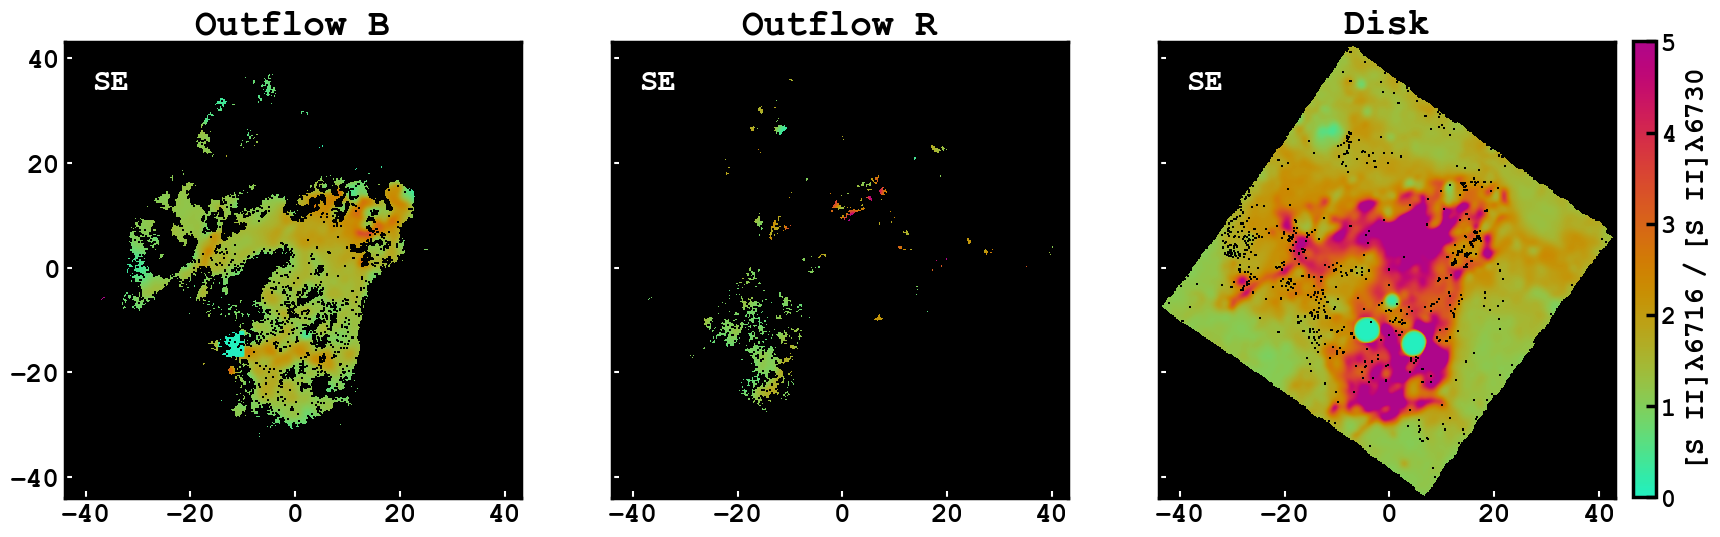

In [117]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              SNR_sii_outb_rat,
              SNR_sii_outr_rat,
              SNR_sii_disk_rat,
              vmin = 0,
              vmax = 5,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)

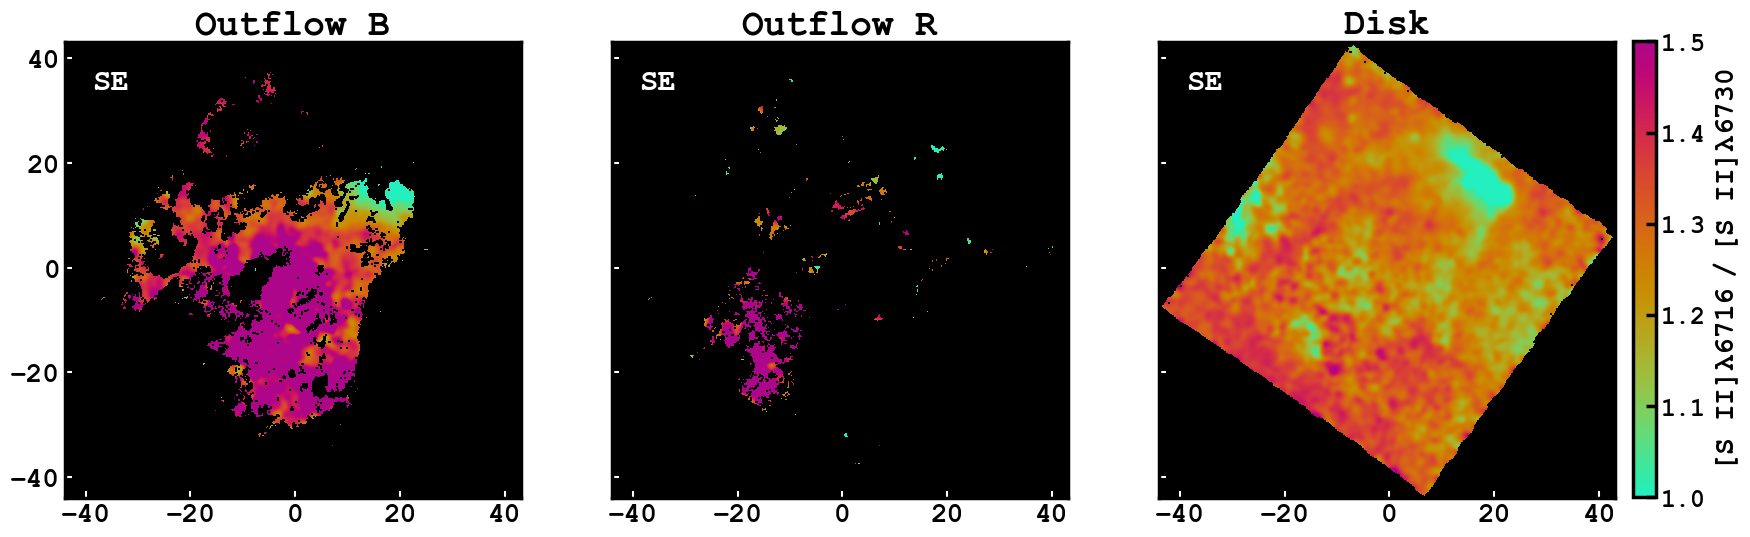

In [119]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              smooth_rats_outb,
              smooth_rats_outr,
              smooth_rats_disk,
              vmin = 1.0,
              vmax = 1.5,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)

In [12]:
np.argwhere(np.isfinite(smooth_rats_outr) & ~np.isfinite(SNR_sii_outr_rat))

array([[  6, 247],
       [ 10, 249],
       [ 10, 262],
       ...,
       [387, 225],
       [397, 172],
       [407, 208]])

In [13]:
np.argwhere(np.isfinite(smooth_rats_outr))
smooth_rats_outr[12,249]
ERR_sii_outr[12,249]
# SNR_sii_outr_rat[12,249]

2.8013198090437306

In [14]:
# edens_outb_5000 = np.loadtxt('../../ngc253/muse/data/%s/edens_outb_5000.txt' % which_smooth)
# edens_outb_6000 = np.loadtxt('../../ngc253/muse/data/%s/edens_outb_6000.txt' % which_smooth)
# edens_outb_8000 = np.loadtxt('../../ngc253/muse/data/%s/edens_outb_8000.txt' % which_smooth)
# edens_outb_10e4 = np.loadtxt('../../ngc253/muse/data/%s/edens_outb.txt' % which_smooth)

# np.mean(np.isfinite(edens_outb_5000)) / np.mean(np.isfinite(edens_outb_8000))

In [69]:
def edens_osterbrock(ne_1e4, T):
    
    return ne_1e4 / ((10**4 / T)**(1/2))

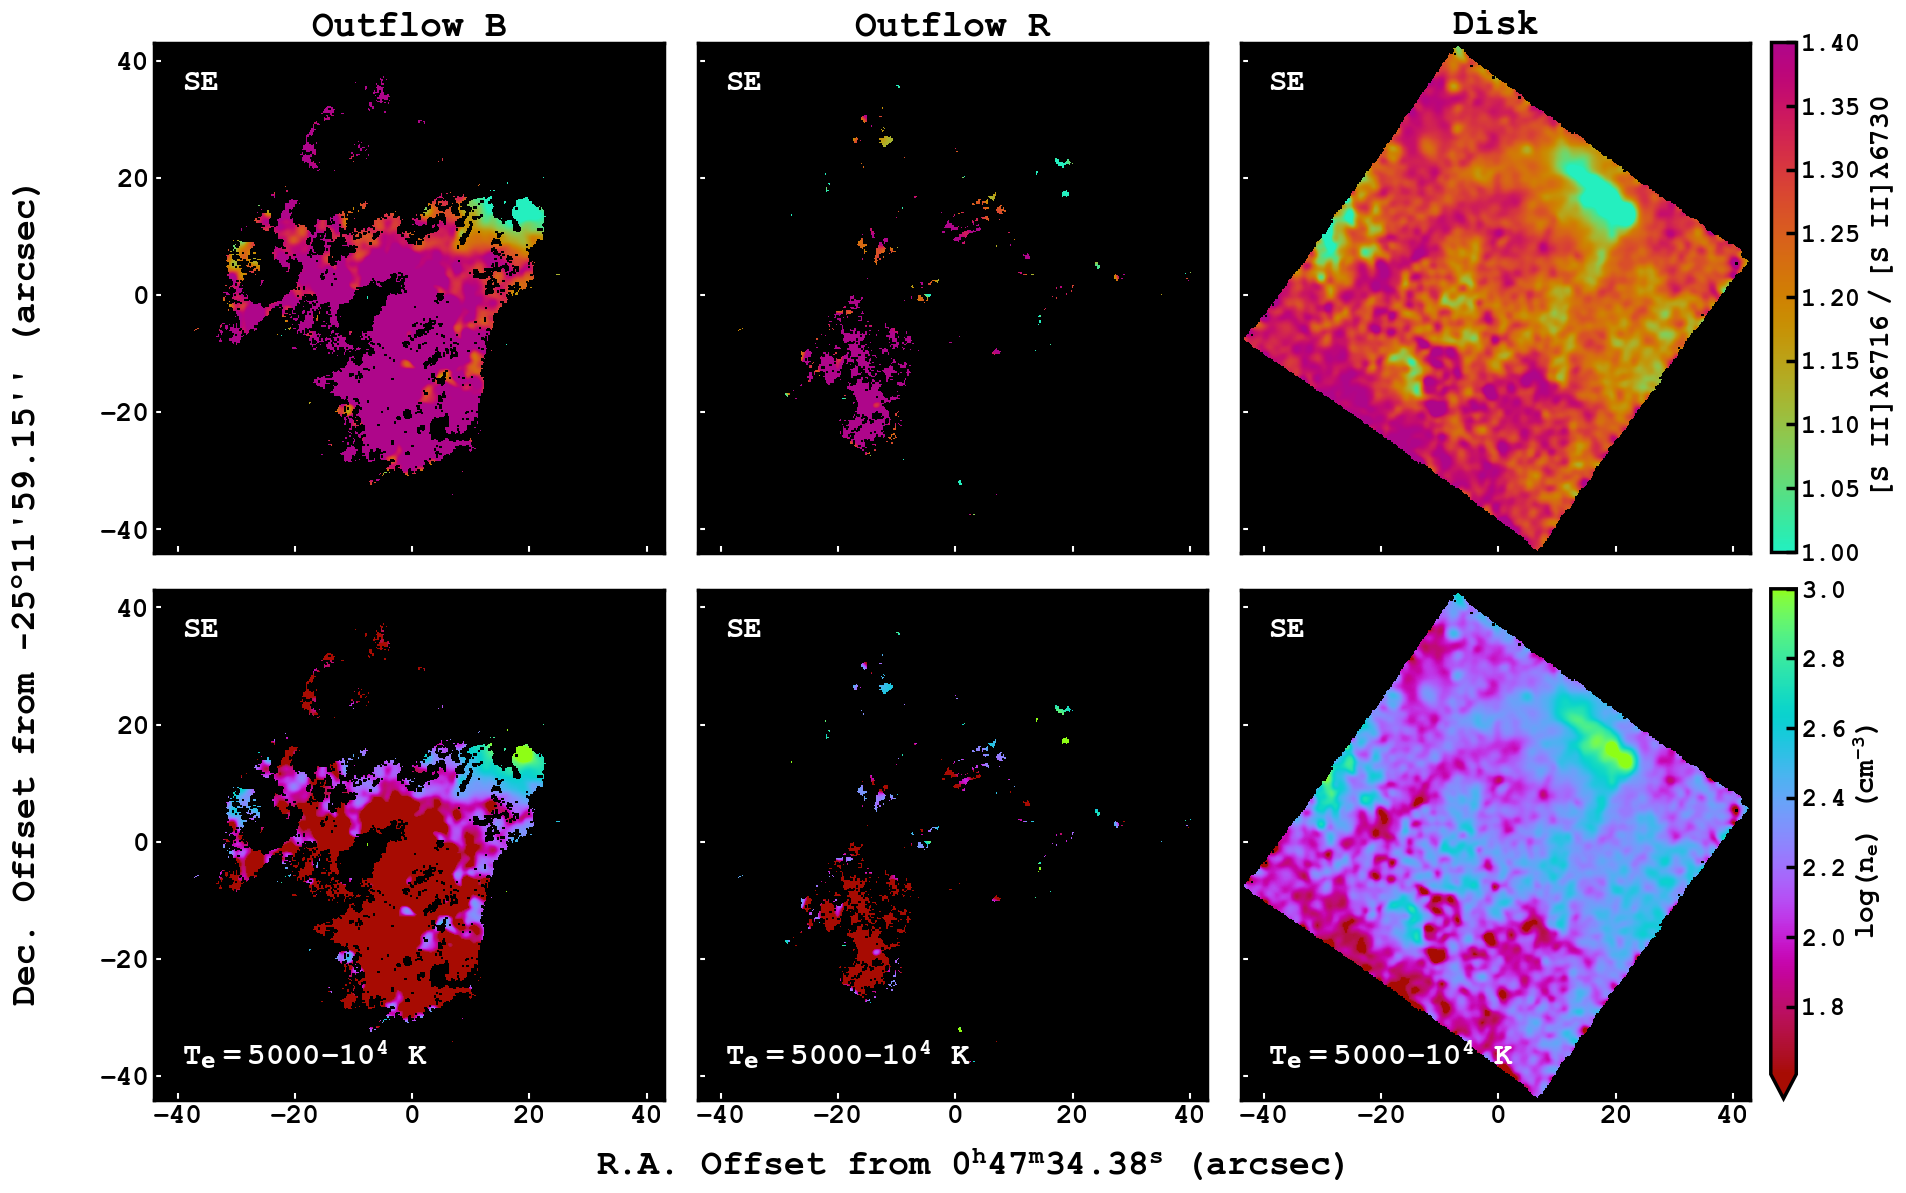

In [149]:
edens_outb = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_outb_6500_smooth.txt' % which_smooth)
edens_outr = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_outr_6500_smooth.txt' % which_smooth)
edens_disk = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_disk_6500_smooth.txt' % which_smooth)

# fill in the gaps where the ratio plateaus
edens_outb[smooth_rats_outb > 1.4] = edens_osterbrock(50, 6500)
edens_outr[smooth_rats_outr > 1.4] = edens_osterbrock(50, 6500)
edens_disk[smooth_rats_disk > 1.4] = edens_osterbrock(50, 6500)
edens_outb[smooth_rats_outb < 0.4] = edens_osterbrock(3000, 6500)
edens_outr[smooth_rats_outr < 0.4] = edens_osterbrock(3000, 6500)
edens_disk[smooth_rats_disk < 0.4] = edens_osterbrock(3000, 6500)

# signal to noise cut
# edens_outb[SNR_sii_outb_rat < 3.] = np.nan
# edens_outr[SNR_sii_outr_rat < 3.] = np.nan
# edens_disk[SNR_sii_disk_rat < 3.] = np.nan

vmin_edens = np.log10(edens_osterbrock(50, 6500))

fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
make_big_plot([ax1, ax2, ax3],
              smooth_rats_outb,
              smooth_rats_outr,
              smooth_rats_disk,
              vmin = 1.0,
              vmax = 1.4,
              titles = True,
              line_label = None,
              cbar_label = '[S II]$\lambda6716~/~$[S II]$\lambda6730$',
              extent=extent,
              cmap = cmap,
              cmap_extend = 'neither')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)

# cmap = cmr.get_sub_cmap('cmr.cosmic_r', 0.3, 1)
# cmap = cmr.get_sub_cmap('cmr.gem', 0.3, 1)
# cmap = cmr.get_sub_cmap('cmr.horizon_r', 0, 1)
cmap = cmr.get_sub_cmap('cmr.neon', 0, 1)
# cmap.set_under('yellow')

make_big_plot([ax4, ax5, ax6],
              np.log10(edens_outb),
              np.log10(edens_outr),
              np.log10(edens_disk),
              vmin_edens,
              vmax = 3,
              titles = False,
              line_label = r'T$_{\rm e} = 5000{-}10^{4}$ K',
              cbar_label = 'log(n$_{e}$) (cm$^{-3}$)',
              extent = extent,
              cmap = cmap,
              cmap_extend = 'min')
#               alpha_outb = alpha_SNR_sii_outb_rat,
#               alpha_outr = alpha_SNR_sii_outr_rat,
#               alpha_disk = alpha_SNR_sii_disk_rat)


fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2)

# plt.savefig('../../ngc253/muse/visuals/edensity_pyneb_osterbrock_smoothgauss.png',bbox_inches='tight', dpi=200)
# plt.savefig('../../ngc253/muse/visuals/edensity_pyneb_osterbrock_smoothgauss.pdf',bbox_inches='tight', dpi=200)
plt.show()

In [132]:
# smooth
edens_outb_smooth = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_outb_6500_smooth.txt' % which_smooth)
edens_outr_smooth = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_outr_6500_smooth.txt' % which_smooth)
edens_disk_smooth = np.loadtxt('../../ngc253/muse/data/edens_%s/edens_disk_6500_smooth.txt' % which_smooth)
edens_outb_smooth[smooth_rats_outb > 1.4] = edens_osterbrock(50, 6500)
edens_outr_smooth[smooth_rats_outr > 1.4] = edens_osterbrock(50, 6500)
edens_disk_smooth[smooth_rats_disk > 1.4] = edens_osterbrock(50, 6500)
edens_outb_smooth[smooth_rats_outb < 0.4] = edens_osterbrock(3000, 6500)
edens_outr_smooth[smooth_rats_outr < 0.4] = edens_osterbrock(3000, 6500)
edens_disk_smooth[smooth_rats_disk < 0.4] = edens_osterbrock(3000, 6500)

print(edens_osterbrock(3000, 6500))

# unsmooth
edens_outb_unsmooth = np.loadtxt('../../ngc253/muse/data/edens_old/edens_outb_6000.txt')
edens_outr_unsmooth = np.loadtxt('../../ngc253/muse/data/edens_old/edens_outr_6000.txt')
edens_disk_unsmooth = np.loadtxt('../../ngc253/muse/data/edens_old/edens_disk_6000.txt')
edens_outb_unsmooth[unsmooth_rats_outb > 1.4] = edens_osterbrock(50, 6500)
edens_outr_unsmooth[unsmooth_rats_outr > 1.4] = edens_osterbrock(50, 6500)
edens_disk_unsmooth[unsmooth_rats_disk > 1.4] = edens_osterbrock(50, 6500)
edens_outb_unsmooth[unsmooth_rats_outb < 0.4] = edens_osterbrock(3000, 6500)
edens_outr_unsmooth[unsmooth_rats_outr < 0.4] = edens_osterbrock(3000, 6500)
edens_disk_unsmooth[unsmooth_rats_disk < 0.4] = edens_osterbrock(3000, 6500)

np.max(edens_disk_unsmooth[np.isfinite(edens_disk_unsmooth)])

2418.677324489565


100000000.0

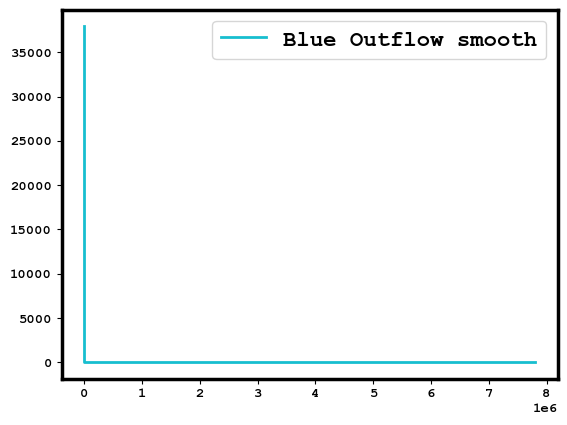

In [130]:
edens_smooth_hist, edens_smooth_bins = np.histogram(edens_outb_smooth[np.isfinite(edens_outb_smooth)],
                                                    bins=100)
edens_unsmooth_hist, edens_unsmooth_bins = np.histogram(edens_outb_unsmooth[np.isfinite(edens_outb_unsmooth)], 
                                                        bins=100)

plt.step(edens_smooth_bins[:-1], edens_smooth_hist, color='tab:cyan', 
         lw=2, label='Blue Outflow smooth')
# plt.step(edens_unsmooth_bins[:-1], edens_unsmooth_hist, color='tab:blue', 
#          lw=2, label='Blue Outflow unsmooth')
plt.legend(fontsize=16)

# plt.xlim(25, 50)
# plt.ylim(0, 200)

In [131]:
np.sort(edens_outb_smooth[np.isfinite(edens_outb_smooth)].flatten())
np.sort(edens_outb_unsmooth[np.isfinite(edens_outb_unsmooth)].flatten())

np.max(edens_outb_unsmooth[np.isfinite(edens_outb_unsmooth)].flatten())

100000000.0

In [154]:
print(np.percentile(edens_outb_smooth[np.isfinite(edens_outb_smooth)],75))
print(np.percentile(edens_outb_unsmooth[np.isfinite(edens_outb_unsmooth)],75))

121.12512686851943
687.0948412617159
